# Calibration of a line to data comparing approaches to dealing with systematic error

In [1]:
import rxmc

Using database version X4-2024-12-31 located in: /home/kyle/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [2]:
from collections import OrderedDict

import corner
import matplotlib.patches as mpatches
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

## Plotting functions

In [3]:
def plot_chains(walker, model, true_params):
    fig, axes = plt.subplots(
        walker.model_chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True
    )
    for i in range(walker.model_chain.shape[1]):
        axes[i].plot(walker.model_chain[:, i])
        axes[i].set_ylabel(f"${model.params[i].latex_name}$ [{model.params[i].unit}]")
        true_value = true_params[model.params[i].name]
        axes[i].hlines(true_value, 0, len(walker.model_chain), "r", linestyle="--")

    axes[-1].plot(walker.log_posterior_record)
    axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

    axes[-1].set_xlabel(r"$i$")
    # plt.legend(title="chains", ncol=3,)

In [4]:
def plot_posterior_corner(walker, true_params):
    fig = corner.corner(
        walker.model_chain,
        labels=[p.name for p in my_model.params],
        label="posterior",
        truths=[true_params["m"], true_params["b"]],
    )
    fig.suptitle("posterior")

In [5]:
def plot_predictive_post(walker, model, x, y_exp, y_err, y_true):
    n_posterior_samples = walker.model_chain.shape[0]
    y = np.zeros((n_posterior_samples, len(x)))
    for i in range(n_posterior_samples):
        sample = walker.model_chain[i, :]
        y[i, :] = model.y(x, *sample)

    upper, median, lower = np.percentile(y, [5, 50, 95], axis=0)
    plt.errorbar(
        x,
        y_exp,
        y_err,
        color="k",
        marker="o",
        linestyle="none",
        label="experiment",
    )

    plt.plot(x, y_true, "k--", label="truth")
    plt.plot(x, median, "m:", label="posterior median")
    plt.fill_between(
        x,
        lower,
        upper,
        alpha=0.5,
        zorder=2,
        label=r"posterior inner 90$^\text{th}$ pctl",
    )
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")

## make the model

In [6]:
class LinearModel(rxmc.physical_model.PhysicalModel):
    def __init__(self):
        params = [
            rxmc.params.Parameter("m", float, "no-units"),
            rxmc.params.Parameter("b", float, "y-units"),
        ]
        super().__init__(params)

    def evaluate(self, observation, m, b):
        return self.y(observation.x, m, b)

    def y(self, x, m, b):
        # useful to have a function hat takes in an array-like x
        # rather than an Observation, e.g. for plotting
        return m * x + b

In [7]:
my_model = LinearModel()

In [8]:
rng = np.random.default_rng(13)

## set up prior

In [9]:
true_params = OrderedDict(
    [
        ("m", 0.6),
        ("b", 2),
    ]
)

In [10]:
prior_mean = OrderedDict(
    [
        ("m", 5),
        ("b", 5),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 2),
        ("b", 2),
    ]
)

In [11]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))
prior_distribution = stats.multivariate_normal(mean, covariance)

In [12]:
systematic_fractional_err = 0.1
# choose a normalization 1 std deviation below the mean
N = 1 - systematic_fractional_err
noise = 0.05
x = np.linspace(0.01, 1.0, 20, dtype=float)
y_true = my_model.y(x, *list(true_params.values()))
y_exp = (y_true + rng.normal(scale=noise * y_true, size=len(x))) * N
y_stat_err = noise * y_exp

Text(0.5, 1.0, 'experimental constraint with bias')

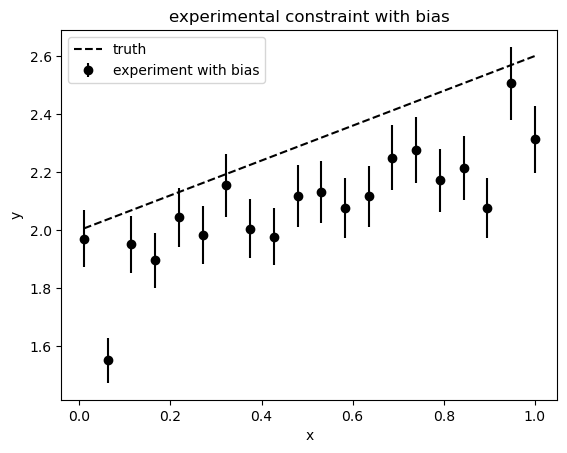

In [13]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(x, y_true, "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("experimental constraint with bias")

## Compare Likelihood Models
We will look at a few different cases:
1. Covariance is fixed to just statistical error (disregarding systematic error)

   \begin{equation}
       \Sigma_{ij} = \delta_{ij} \sigma_{stat,i}^2
   \end{equation}

3. Covariance is just statistical error, but we fit the magnitude of the statistical noise $\eta$ (disregarding systematic error). This means the covariance is not fixed, but will be updated during calibration.

   \begin{equation}
       \Sigma_{ij} = \delta_{ij} \eta^2
   \end{equation}


5. Systematic error is included properly in covariance, making the covariance a function of the model prediction. Again, this means the covariance is not fixed, but will be updated during calibration.

    \begin{equation}
       \Sigma_{ij}(\alpha) = \delta_{ij} \sigma_{stat,i}^2 + \sigma_N^2 y_m(x_i; \alpha) y_m(x_j; \alpha)
   \end{equation}

7. Systematic error is included improperly in covariance, using the experimental $y(x_i)$ instead of the model prediction $y_m(x_i;\alpha)$. In this case the covariance is again fixed.

    \begin{equation}
       \Sigma_{ij} = \delta_{ij} \sigma_{stat,i}^2 + \sigma_N^2 y(x_i) y(x_j)
   \end{equation}


In [14]:
# 1 and 2
obs_stat_only = rxmc.observation.Observation(
    x=x,
    y=y_exp,
    y_stat_err=y_stat_err,
)

# 3
obs_sys_norm_correct = rxmc.observation.Observation(
    x=x,
    y=y_exp,
    y_stat_err=y_stat_err,
    y_sys_err_normalization=systematic_fractional_err,
)

# 4
obs_sys_norm_wrong = rxmc.observation.FixedCovarianceObservation(
    x=x,
    y=y_exp,
    covariance=np.diag(y_stat_err**2)
    + systematic_fractional_err**2 * np.outer(y_exp, y_exp),
)

## set up likelihood models and constraints

In [15]:
# 1 and 3
likelihood = rxmc.likelihood_model.LikelihoodModel()

# 4
likelihood_fixed_cov = rxmc.likelihood_model.FixedCovarianceLikelihood()


# 2 - a special likelihood model that takes in the noise fraction as a parameter
likelihood_unknown_stat = rxmc.likelihood_model.UnknownNoiseFractionErrorModel()

In [16]:
# 1
corpus_stat_only = rxmc.corpus.Corpus(
    [
        rxmc.constraint.Constraint(
            [obs_stat_only],
            my_model,
            likelihood,
        )
    ]
)

# 2
corpus_unknown_stat = rxmc.corpus.Corpus(
    constraints=[],
    parametric_constraints=[
        rxmc.constraint.Constraint(
            [obs_stat_only],
            my_model,
            likelihood_unknown_stat,
        )
    ],
)

# 3
corpus_sys_correct = rxmc.corpus.Corpus(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_correct],
            my_model,
            likelihood,
        )
    ]
)

# 4
corpus_sys_wrong = rxmc.corpus.Corpus(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_wrong],
            my_model,
            likelihood_fixed_cov,
        )
    ]
)

In [17]:
def proposal_distribution_model(x):
    return stats.multivariate_normal.rvs(
        mean=x, cov=prior_distribution.cov / 1000, random_state=rng
    )

In [18]:
my_model_sampling_config = rxmc.param_sampling.SamplingConfig(
    params=my_model.params,
    starting_location=prior_distribution.mean,
    proposal=proposal_distribution_model,
    prior=prior_distribution,
)

## Run option 1: fixed covariance, statistical error only

In [19]:
walker1 = rxmc.walker.Walker(
    my_model_sampling_config,
    corpus_stat_only,
    rng=rng,
)

In [20]:
%%time
walker1.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.316
CPU times: user 3.44 s, sys: 457 ms, total: 3.9 s
Wall time: 3.38 s


0.3158

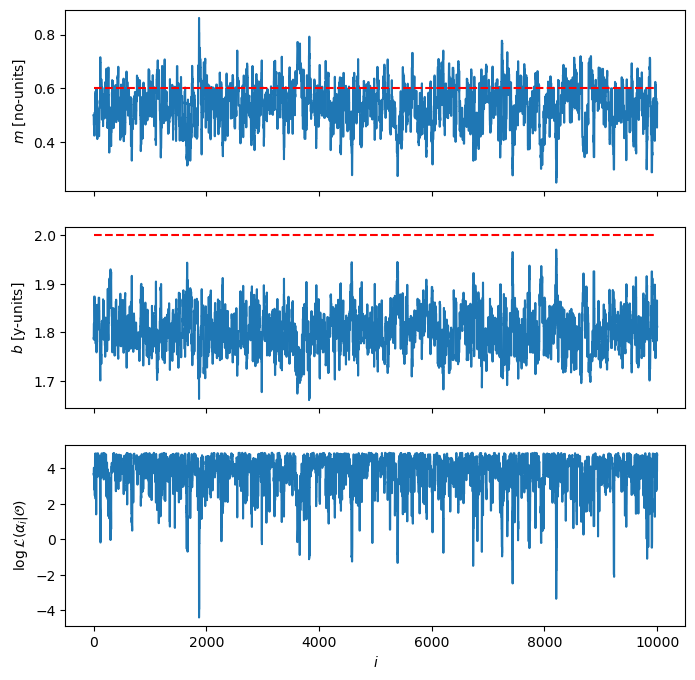

In [21]:
plot_chains(walker=walker1, model=my_model, true_params=true_params)

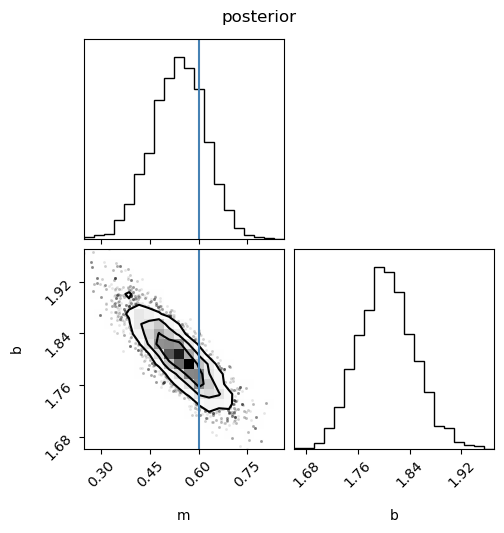

In [22]:
plot_posterior_corner(walker=walker1, true_params=true_params)

Text(0.5, 1.0, 'option 1: fixed statistical error, systematic ignored')

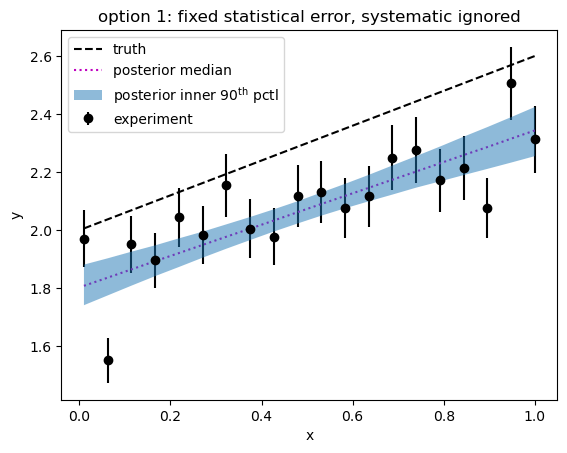

In [23]:
plot_predictive_post(
    walker=walker1, model=my_model, x=x, y_exp=y_exp, y_err=y_stat_err, y_true=y_true
)
plt.title("option 1: fixed statistical error, systematic ignored")

## Run option 2: unknown statistical error

We need to come up with a prior for the noise for option 2. We will keep it fairly wide and centered about the reported value.

In [24]:
noise_prior = stats.norm(loc=noise, scale=0.1)

In [25]:
def proposal_distribution_noise(x):
    return stats.norm.rvs(loc=x, scale=0.1, random_state=rng)

In [26]:
noise_sampling_config = rxmc.param_sampling.SamplingConfig(
    params=likelihood_unknown_stat.params,
    starting_location=noise_prior.mean(),
    proposal=proposal_distribution_noise,
    prior=noise_prior,
)

In [27]:
def proposal_distribution_model_unknown_stat(x):
    return stats.multivariate_normal.rvs(
        mean=x, cov=prior_distribution.cov / 10, random_state=rng
    )

In [28]:
model_sampling_config2 = rxmc.param_sampling.SamplingConfig(
    params=my_model.params,
    starting_location=prior_distribution.mean,
    proposal=proposal_distribution_model_unknown_stat,
    prior=prior_distribution,
)

In [29]:
walker2 = rxmc.walker.Walker(
    model_sample_conf=model_sampling_config2,
    corpus=corpus_unknown_stat,
    likelihood_sample_confs=[noise_sampling_config],
    rng=rng,
)

In [30]:
%%time
walker2.walk(
    n_steps=10000,
    burnin=1000,
    batch_size=100,
    verbose=False,
)

CPU times: user 5.46 s, sys: 8.9 ms, total: 5.46 s
Wall time: 5.47 s


(0.8477, [0.7043])

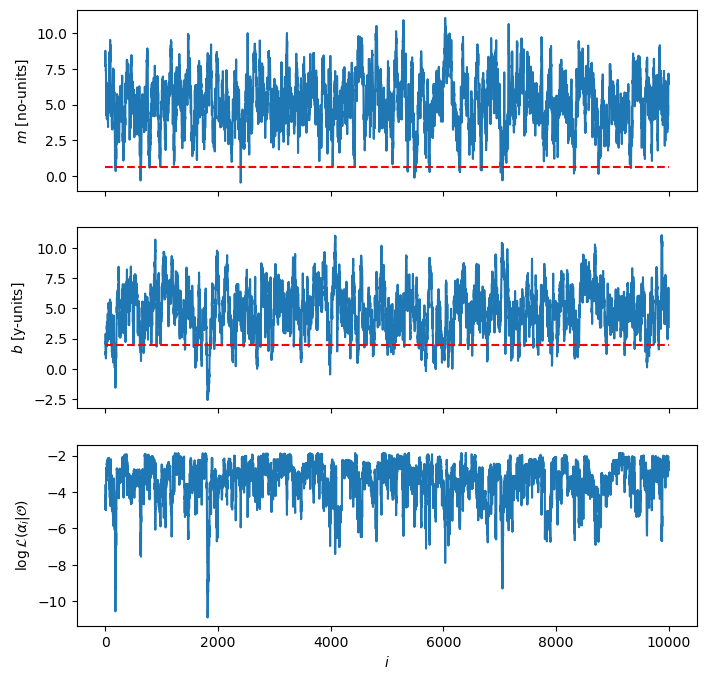

In [31]:
plot_chains(walker=walker2, model=my_model, true_params=true_params)

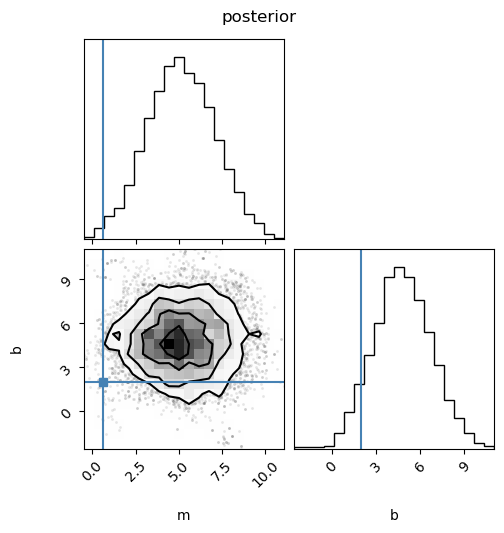

In [32]:
plot_posterior_corner(walker=walker2, true_params=true_params)

Text(0.5, 1.0, 'option 2: unknown statistical error, systematic ignored')

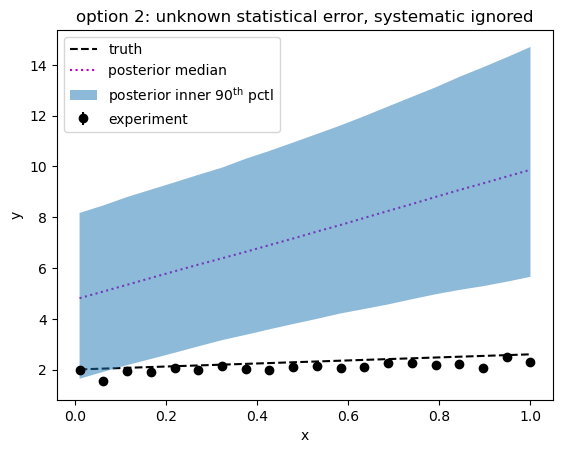

In [33]:
plot_predictive_post(
    walker=walker2, model=my_model, x=x, y_exp=y_exp, y_err=y_stat_err, y_true=y_true
)
plt.title("option 2: unknown statistical error, systematic ignored")

## Run option 3: correct formulation of the systematic error

In [34]:
walker3 = rxmc.walker.Walker(
    my_model_sampling_config,
    corpus_sys_correct,
    rng=rng,
)

In [35]:
%%time
walker3.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.732
CPU times: user 3.54 s, sys: 17.3 ms, total: 3.56 s
Wall time: 3.54 s


0.7318

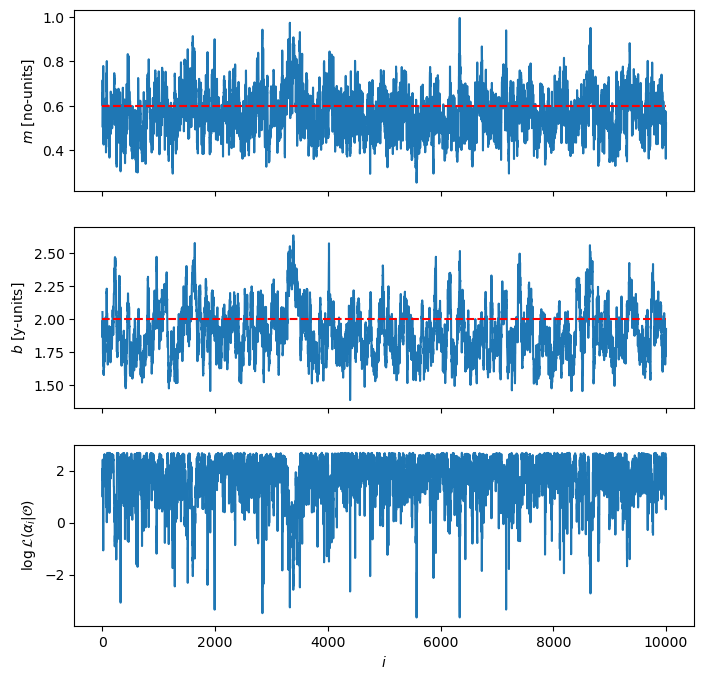

In [36]:
plot_chains(walker=walker3, model=my_model, true_params=true_params)

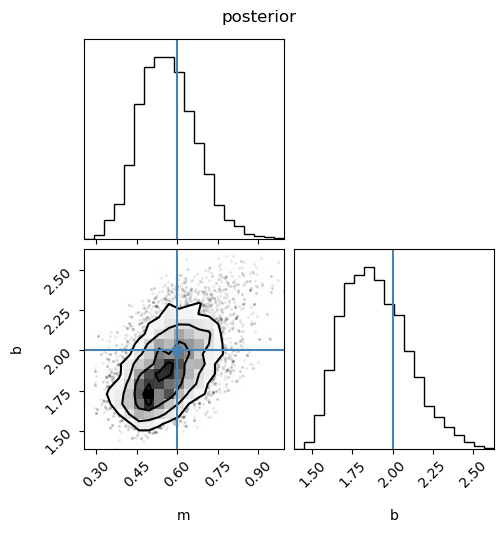

In [37]:
plot_posterior_corner(walker=walker3, true_params=true_params)

Text(0.5, 1.0, 'option 3: systematic included correctly')

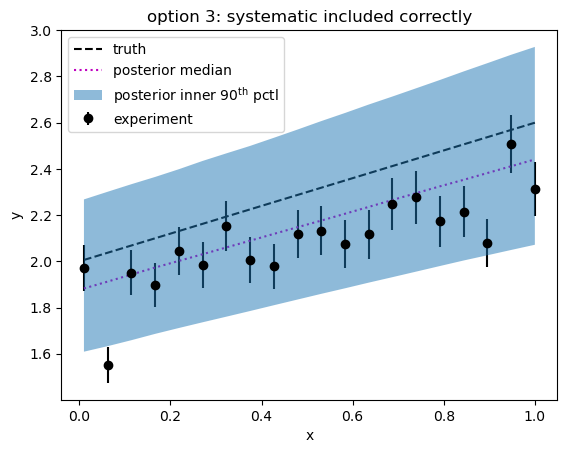

In [38]:
plot_predictive_post(
    walker=walker3, model=my_model, x=x, y_exp=y_exp, y_err=y_stat_err, y_true=y_true
)
plt.title("option 3: systematic included correctly")

## Run option 4: incorrect formulation of the systematic error

In [39]:
walker4 = rxmc.walker.Walker(
    my_model_sampling_config,
    corpus_sys_wrong,
    rng=rng,
)

In [40]:
%%time
walker4.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.714
CPU times: user 2.89 s, sys: 1.77 ms, total: 2.89 s
Wall time: 2.88 s


0.7137

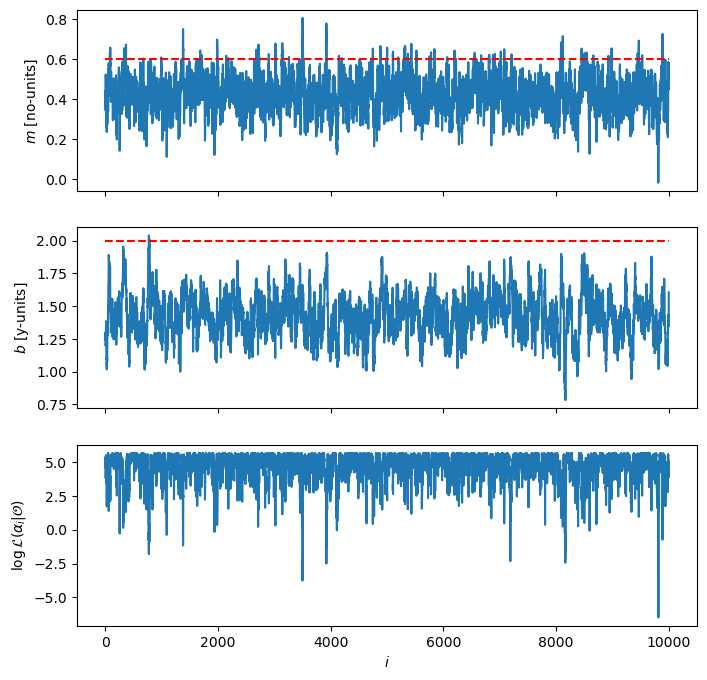

In [41]:
plot_chains(walker=walker4, model=my_model, true_params=true_params)

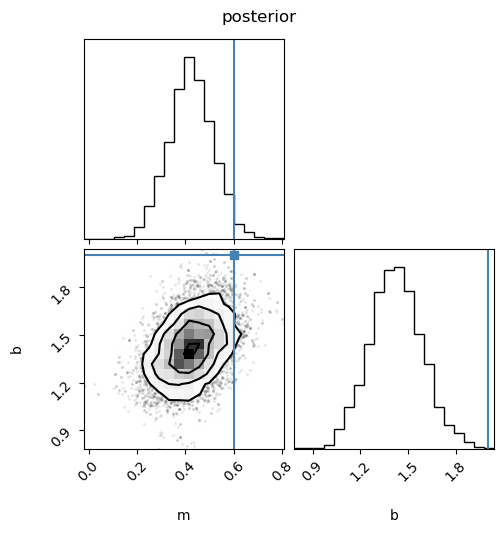

In [42]:
plot_posterior_corner(walker=walker4, true_params=true_params)

Text(0.5, 1.0, 'option 4: systematic included incorrectly')

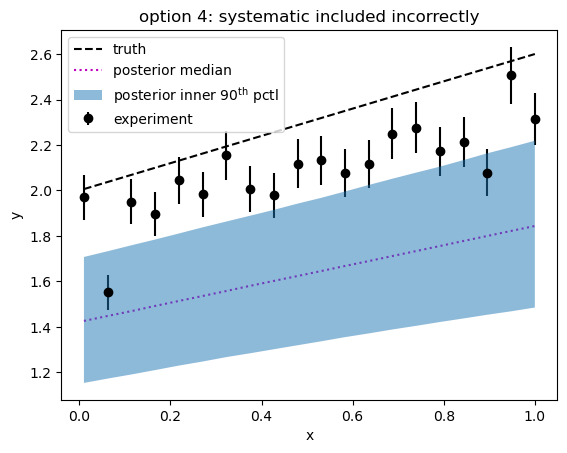

In [43]:
plot_predictive_post(
    walker=walker4, model=my_model, x=x, y_exp=y_exp, y_err=y_stat_err, y_true=y_true
)
plt.title("option 4: systematic included incorrectly")